In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import yaml

In [3]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [4]:
from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [5]:
from scripts.generate_stats_v1 import plot_stats

## Trade behaviour

In [14]:
trade_df = pd.read_csv('sources/input/actor_trade/single_trade.csv')

In [15]:
trade_df.head()

,timestamp,action,cash_volume
0,1,borrow,0.002636
1,2,borrow,0.004011
2,3,borrow,0.002832
3,4,borrow,0.000882
4,5,lend,0.000994


In [ ]:
cash = 0.5

In [16]:
trade_df.cash_volume.describe()

count    5.255990e+05
mean     1.333184e-03
std      1.007713e-03
min      5.944620e-09
25%      5.344915e-04
50%      1.127402e-03
75%      1.919005e-03
max      8.257631e-03
Name: cash_volume, dtype: float64

In [8]:
LENGTH = 24 * 60

In [9]:
trade_df['day'] = (trade_df.timestamp / LENGTH).astype('int') * LENGTH
trade_df['net_volume'] = trade_df.apply(lambda row: row['cash_volume'] if row['action'] == 'lend'
                                                       else -row['cash_volume'], axis=1)

In [10]:
trade_df = trade_df[trade_df.day < 180 * LENGTH]

In [11]:
agg_trade = trade_df.groupby(['day', 'action'], as_index=False).agg({'net_volume': 'sum'})

In [12]:
net_trade = agg_trade.groupby('day', as_index=False).agg({'net_volume': 'sum'})

In [13]:
agg_trade['cum_volume'] = agg_trade.groupby('action')['net_volume'].transform(lambda x: np.cumsum(x))

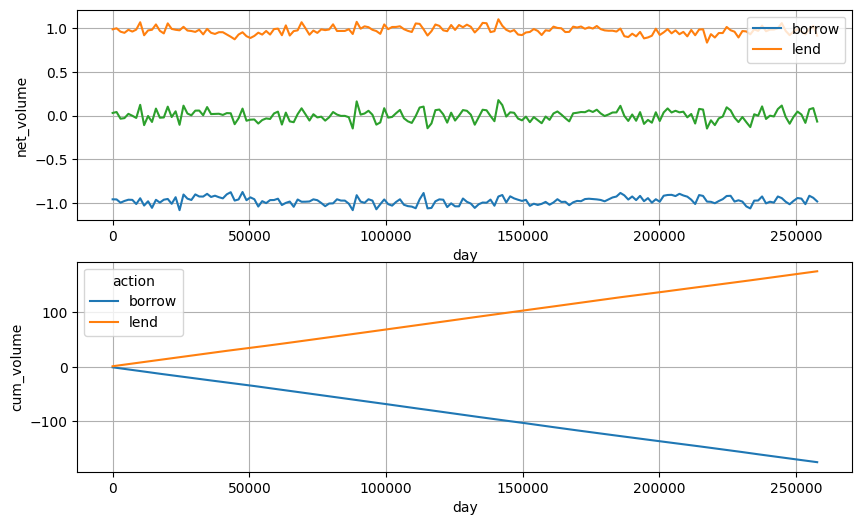

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=agg_trade, x='day', y='net_volume', hue='action', 
             ax=axs[0])

sns.lineplot(data=net_trade, x='day', y='net_volume', 
             ax=axs[0])

axs[0].grid(True)

sns.lineplot(data=agg_trade, x='day', y='cum_volume', hue='action', 
             ax=axs[1])
axs[1].grid(True)

plt.show()

## Simulation for Yield

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [10]:
%%writefile config/yield_v1.yml

# time unit: minute

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 525600
    initial_cash: 0.5
    initial_bond: 0.5256355481880121
#     bond_burning: 1

  fee:
    rate: 0.

  trader:
    trade_data: 'sources/input/actor_trade/single_trade2.csv'

  pricing_config:
      pricing_method: 'yield-v1'
      params:
        
  tracking:
    dir: 'data/tracking/yield_v1'


Overwriting config/yield_v1.yml


In [11]:
with open('config/yield_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|███████████████████████████████████████████████████████████████████████| 525500/525500 [00:48<00:00, 10927.08it/s]


Total_burn: 0

Saving tracking data to data/tracking/yield_v1

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

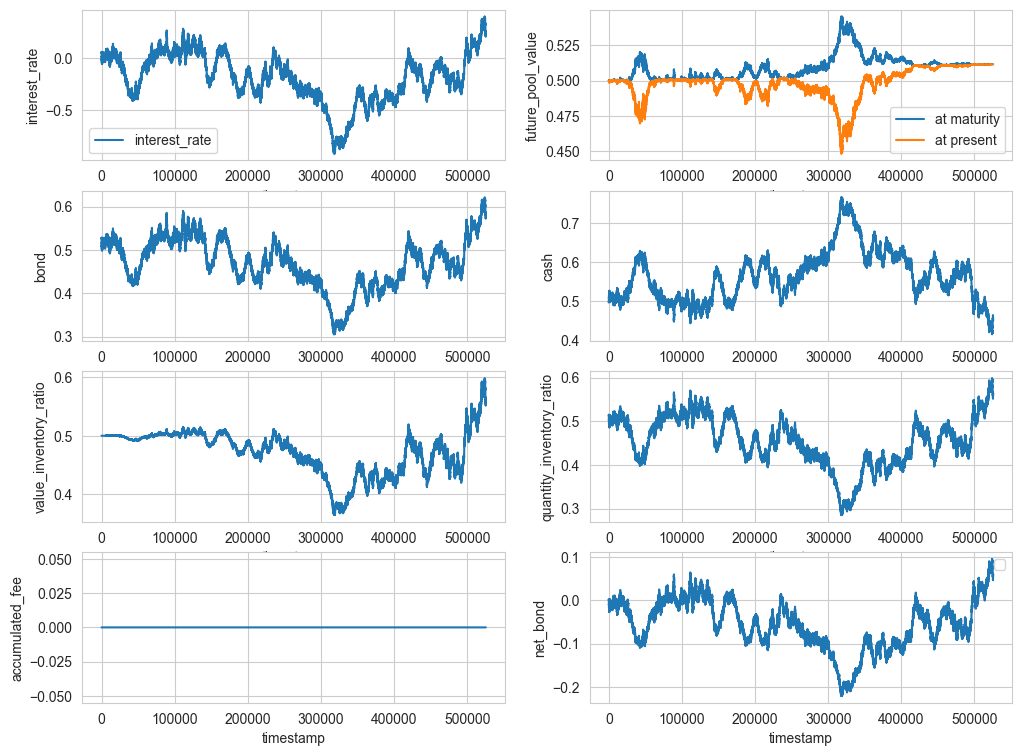

In [12]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/yield_v1', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Simulation for Logit Notional

In [26]:
%%writefile config/logit_notional_v1.yml

version_name: 'linear-notional-v1'

# time unit: minute
    
config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 525600
    initial_cash: 0.5
    initial_bond: 0.5256355481880121

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'logit-notional'
      params:
        scalar: 50
        anchor: 1.05
            
  other-protocol:
    type: 'CIR'
    params:
        a: 5
        b: 0.05
        sigma: 0.1
        r0: 0.04

  arbitrageur:
    strategy: 'naive-arbitrageur'
    params:
      estimate_func: 'notional'
      kappa: 0.1
      r_star: 0.05

  trader:
    trade_data: 'sources/input/actor_trade/single_trade2.csv'

  tracking:
    dir: 'data/tracking/logit_notional'

Overwriting config/logit_notional_v1.yml


In [27]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [28]:
with open('config/logit_notional_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:15<00:00, 6932.06it/s]


Total_burn: 0

Saving tracking data to data/tracking/logit_notional

------------------ Done simulation ------------------


In [34]:
def yield_price_impact_coeff(x, y, tau, *args, **kwargs):
    MAX_D_PCT=0.03
    dx = x * MAX_D_PCT

    p0 = (y/x)**tau

    alpha = 1-tau

    new_x = x + dx
    new_y = (x**alpha + y**alpha - new_x**alpha)**(1/alpha)
    p1 = (new_y/new_x)**tau

    d_price = abs(p1 - p0) / p0
    coefficient = d_price / MAX_D_PCT

    return coefficient


yield_price_impact_coeff(0.5, 0.5, 0.5)

0.9780481223804557

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

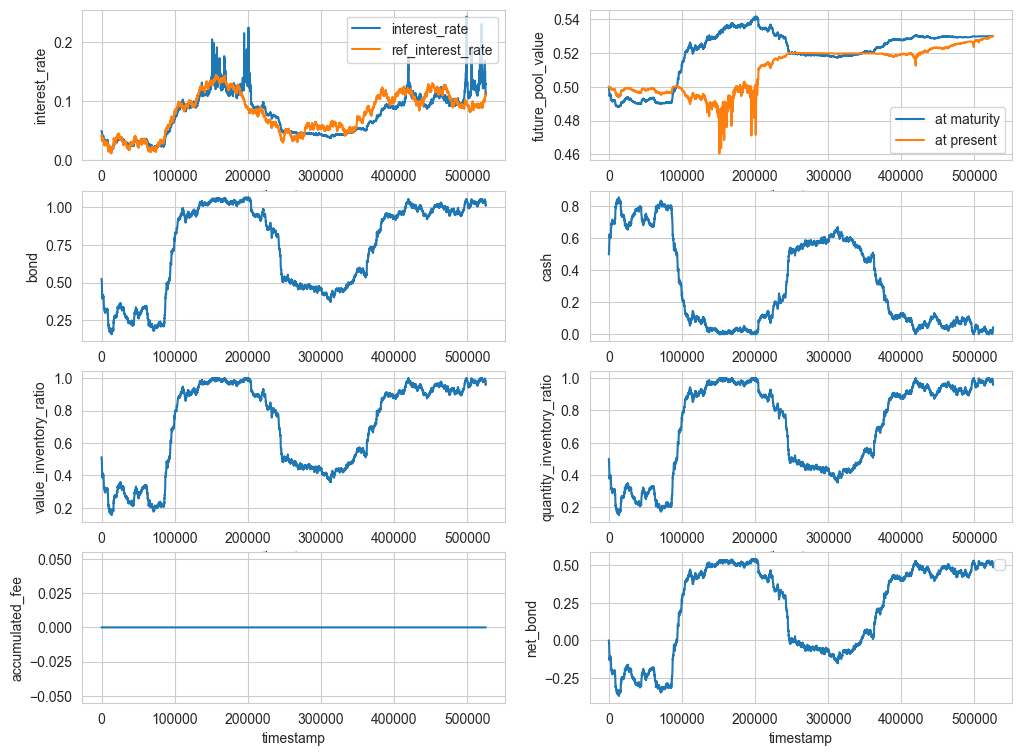

In [29]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/logit_notional/', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Proposed logit

$p = \frac{X_0}{X_0 + y_0}$

$r = \kappa logit(p) + r^{\star}$

$C_1 = y_0[e^{\kappa^{-1}(r_0 - r^\star)} + 1]^{\tau\kappa + 1}$

$\alpha = \frac{1}{1 + \tau\kappa}$ 

$K = e^{-\tau r^{\star} \alpha}$

$C_2 = C_1^{\alpha}$

$Kx^\alpha + y^\alpha = C_2$  

At time t, suppose the state of pool is $(x_0, y_0, r_0)$, and there is a trade dy to the pool. 

-> $Kx_{0}^{\alpha} + y_0^{\alpha} = C_2$ 

-> $r_{0} = r^{\star} - \kappa \bigr[ln(K) + \alpha ln(\frac{x_0}{y_0})\bigr]$

-> $K(x + dx)^{\alpha} + (y+dy)^{\alpha} = K x_0^{\alpha} + y_0^{\alpha}$

In [46]:
_user_defined_func_path = "scripts/price_functions/price_v1.py"

In [47]:
%%writefile {_user_defined_func_path}

import numpy as np
from scipy.special import logit


def calculate_price(x, y, dx, dy, time_to_maturity, maturity_length) -> float:
    tau = time_to_maturity

    r_star = 0.05
    kappa = 0.02

    alpha = 1 / (1 + tau * kappa)
    Br = np.exp(-r_star * tau) 
    
    C = (x * Br) ** alpha + y ** alpha

    if dx != 0:
        new_x = x + dx
        new_y = (C - (Br * new_x) ** alpha) ** (1 / alpha)
        dy = new_y - y
    elif dy != 0:
        new_y = y + dy
        new_x = (C - new_y ** alpha) ** (1 / alpha) / Br
        dx = new_x - x

    if abs((x * Br) ** alpha + y ** alpha - ((x + dx) * Br) ** alpha - (y + dy) ** alpha) > 0.00001:
        raise Exception('Something wrong with ODE!')
    
    r0 = r_star * alpha + kappa * alpha * np.log(x / y)
    if abs(logit(x * np.exp(-r0 * tau) / (x * np.exp(-r0 * tau) + y)) * kappa + r_star - r0) > 0.00001:
        raise Exception('R0 not match!')

    if dx == 0 and dy == 0:
        dy = -np.exp(-tau * r0)
        dx = 1

    price = abs(dy / dx)

    return price

Overwriting scripts/price_functions/price_v1.py


In [48]:
%%writefile config/user_defined_v1.yml

version_name: 'v1'

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 525600
    initial_cash: 0.5
    initial_bond: 0.5256355481880121
    bond_burning: 1

  fee:
    rate: .000

  pricing_config:
      pricing_method: 'user-defined'
      params:
        price_function: 'scripts/price_functions/price_v1.py'

  trader:
    trade_data: 'sources/input/actor_trade/single_trade2.csv'

  tracking:
    dir: 'data/tracking/v1.1'

Overwriting config/user_defined_v1.yml


In [49]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [51]:
with open('config/user_defined_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:24<00:00, 6205.32it/s]


Total_burn: -0.020346405198408052

Saving tracking data to data/tracking/v1.1

------------------ Done simulation ------------------


In [52]:
%autoreload 2

from scripts.generate_stats_v1 import plot_stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

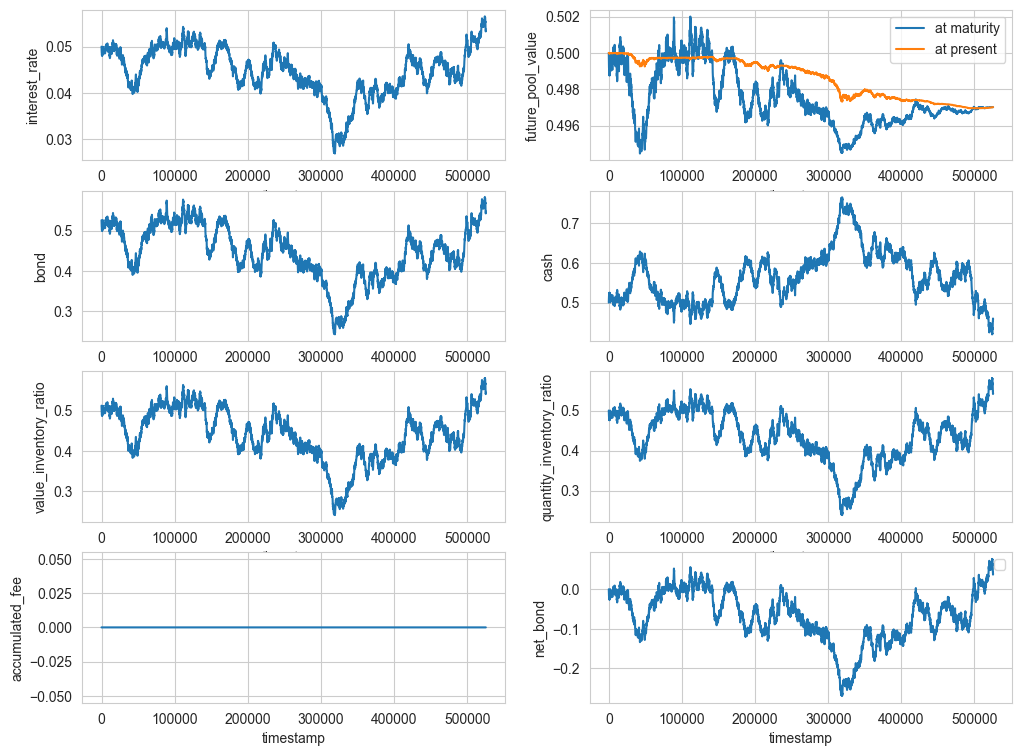

In [53]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/v1.1', 'ALL_INFORMATION.json', fig_size=(12, 9))

In [38]:
def lob_density(x, y, tau, kappa, r_star, u):
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    r0 = kappa * np.log(K*x**(alpha)/y**(alpha)) + r_star
    
    k1 = K**(-1/(tau*kappa)) * np.exp(-r0/kappa)
    
    c1 = y * (np.exp(1/kappa * (r0 - r_star)) + 1)**(tau*kappa + 1)
    c2 = c1**(1/(1 + tau*kappa))

#     dx_du = -c2*(1 + tau*kappa)*k1*(1/(tau*kappa)) \
#             * (K + k1*u**(1/(tau*kappa)))**(-2-tau*kappa) \
#             * u**(1/(tau*kappa)-1)

    density = c2*(1+tau*kappa)/(tau*kappa)*K**(-1/(tau*kappa))*np.exp(-r0/kappa+r0*tau) \
                * (K + K**(-1/(tau*kappa))*np.exp(-r0/kappa)*u**(1/(tau*kappa)))**(-2-tau*kappa) \
                * u**(1/(tau*kappa)-1)
    
    return density

In [39]:
kappa = 0.15
r_star = 0.05

In [40]:
price = np.linspace(0.01, 2, 1000)

In [41]:
x0=1
y0=1 

tau = 0.99 

lob = []

ts = [0.1, 0.5, 0.99, 5, 10]

for tau in ts: 

    lob.append(pd.DataFrame(
        {
            'density': pd.Series(lob_density(x0, y0, tau, kappa, r_star, price)),
            'price': pd.Series(price), 
            'tau': str(tau), 
            'x': x0, 
            'y': y0, 
        }
    )
    )
    
lob = pd.concat(lob)

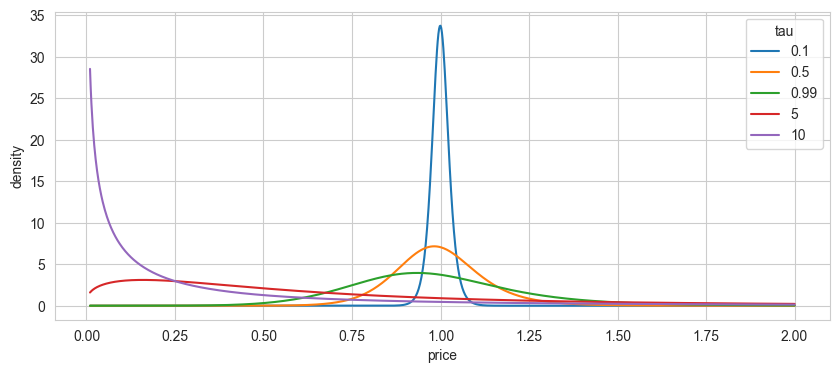

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))

a = sns.lineplot(data=lob, x='price', y='density', hue='tau', palette='tab10')

# for tau, color in zip(ts, sns.color_palette('tab10')): 
#     plt.axvline(np.exp(-r_star * tau), ymin=0, ymax=0.9, color=color, 
#                 linewidth=1, linestyle='dashed')

$$
P_0 = e^{-r0*\tau}
$$

In [18]:
import json


def read_data(folder_dir, file_path):
    file_path = os.path.join(folder_dir, file_path)

    with open(file_path, 'r') as file:
        data = json.load(file)

    _df = pd.DataFrame(data['value'])
    _df['timestamp'] = data['timestamp']
    _df['pool_address'] = data['pool_address']

    return _df

In [19]:
df = read_data('data/tracking/v1.1/', 'ALL_INFORMATION.json')

In [20]:
df

,cash,bond,net_bond,time_to_maturity,accumulated_fee,interest_rate,timestamp,pool_address
0,1.000000,1.051271,-0.000000,525599,0.0,0.050000,1,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
1,1.033902,1.015788,-0.035483,525499,0.0,0.041174,101,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
2,1.049416,0.999654,-0.051617,525399,0.0,0.037144,201,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
3,1.066265,0.982207,-0.069064,525299,0.0,0.032770,301,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
4,1.066912,0.981538,-0.069733,525199,0.0,0.032603,401,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
...,...,...,...,...,...,...,...,...
5250,0.809939,1.246756,0.195484,599,0.0,0.114682,525001,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
5251,0.818678,1.238016,0.186744,499,0.0,0.112020,525101,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
5252,0.817528,1.239166,0.187895,399,0.0,0.112374,525201,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187
5253,0.842188,1.214504,0.163233,299,0.0,0.104904,525301,0xrdokaftdklfczymohkjdgfpacwqcmz1697903187


<Axes: >

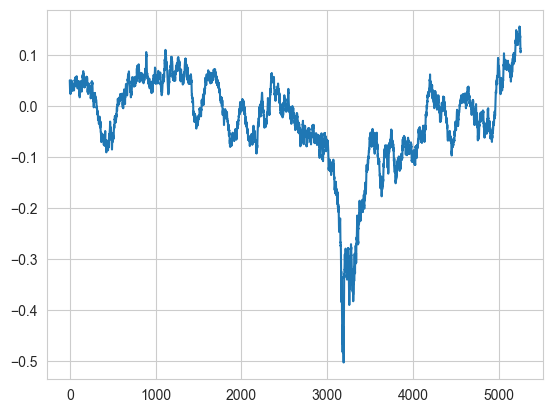

In [21]:
df.query('abs(interest_rate) < 2').interest_rate.plot()